In [6]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [7]:
# Define column names for the wine dataset
column_names = ['class', 'alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 
                'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
                'proanthocyanins', 'color_intensity', 'hue', 
                'od280_od315_of_diluted_wines', 'proline']

# Read the CSV file with the defined column names
df = pd.read_csv("wine/wine.data", names=column_names)

In [16]:
display(df.head())

class  alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  flavanoids  \
0      1    14.23        1.71  2.43               15.6        127        3.06   
1      1    13.20        1.78  2.14               11.2        100        2.76   
2      1    13.16        2.36  2.67               18.6        101        3.24   
3      1    14.37        1.95  2.50               16.8        113        3.49   
4      1    13.24        2.59  2.87               21.0        118        2.69   

   nonflavanoid_phenols  proanthocyanins  color_intensity   hue  
0                  0.28             2.29             5.64  1.04  
1                  0.26             1.28             4.38  1.05  
2                  0.30             2.81             5.68  1.03  
3                  0.24             2.18             7.80  0.86  
4                  0.39             1.82             4.32  1.04

In [13]:
df.drop(columns=['od280_od315_of_diluted_wines', 'proline', 'total_phenols'], inplace=True)

In [14]:


def analyze_feature_impacts(df, feature_list, target='class'):
    """
    Evaluates all combinations and analyzes the incremental impact of each feature addition.
    """
    # First get all combinations and their MSEs
    combinations_results = []
    for r in range(1, len(feature_list) + 1):
        for feature_combo in combinations(feature_list, r):
            X = df[list(feature_combo)]
            y = df[target]
            
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            
            X_train, X_test, y_train, y_test = train_test_split(
                X_scaled, y, test_size=0.2, random_state=42
            )
            
            model = LinearRegression()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            
            combinations_results.append({
                'features': feature_combo,
                'num_features': len(feature_combo),
                'mse': mse,
                'rmse': np.sqrt(mse)
            })
    
    # Create impact analysis
    impact_results = []
    for result in combinations_results:
        if len(result['features']) > 1:
            current_mse = result['mse']
            current_features = set(result['features'])
            
            # Find the MSE for each subset with one feature removed
            for feature in result['features']:
                subset_features = current_features - {feature}
                
                # Find the corresponding base MSE
                base_mse = next(r['mse'] for r in combinations_results 
                              if set(r['features']) == subset_features)
                
                impact_results.append({
                    'base_features': tuple(sorted(subset_features)),
                    'added_feature': feature,
                    'final_features': result['features'],
                    'base_mse': base_mse,
                    'new_mse': current_mse,
                    'mse_reduction': base_mse - current_mse,
                    'relative_improvement': ((base_mse - current_mse) / base_mse) * 100
                })
    
    # Convert to DataFrame and sort by MSE reduction
    impact_df = pd.DataFrame(impact_results)
    impact_df = impact_df.sort_values('mse_reduction', ascending=False)
    

    # Convert combinations results to DataFrame
    combinations_df = pd.DataFrame(combinations_results)
    combinations_df = combinations_df.sort_values('mse')
    
    return combinations_df, impact_df

# List of features for wine dataset except class
features_to_test = df.columns.tolist()[1:]
combinations_df, impact_df = analyze_feature_impacts(df, features_to_test)


display(combinations_df)
display(impact_df.sample(20))



features  num_features  \
755  (alcohol, alcalinity_of_ash, flavanoids, proan...             6   
927  (alcohol, alcalinity_of_ash, magnesium, flavan...             7   
491  (alcohol, alcalinity_of_ash, flavanoids, color...             5   
929  (alcohol, alcalinity_of_ash, flavanoids, nonfl...             7   
747  (alcohol, alcalinity_of_ash, magnesium, flavan...             6   
..                                                 ...           ...   
4                                         (magnesium,)             1   
28                                    (ash, magnesium)             2   
2                                               (ash,)             1   
32                              (ash, color_intensity)             2   
8                                   (color_intensity,)             1   

          mse      rmse  
755  0.085377  0.292194  
927  0.085460  0.292335  
491  0.086119  0.293461  
929  0.086519  0.294142  
747  0.086619  0.294312  
..        ...       ...  
4    0.582913  0.763488  
28   0.583010  0.763551  
2    0.597193  0.772783  
32   0.608802  0.780258  
8    0.618554  0.786482  

[1023 rows x 4 columns]

base_features         added_feature  \
1124                 (ash, color_intensity, flavanoids)       proanthocyanins   
397                        (color_intensity, magnesium)            flavanoids   
420             (nonflavanoid_phenols, proanthocyanins)            flavanoids   
3791  (alcalinity_of_ash, color_intensity, flavanoid...                   hue   
4644  (alcalinity_of_ash, color_intensity, flavanoid...             magnesium   
1074           (flavanoids, magnesium, proanthocyanins)                   ash   
2852  (alcohol, color_intensity, flavanoids, hue, ma...     alcalinity_of_ash   
1596  (alcalinity_of_ash, alcohol, flavanoids, nonfl...                   ash   
5068  (alcohol, ash, color_intensity, hue, magnesium...            flavanoids   
2150  (alcalinity_of_ash, color_intensity, flavanoid...            malic_acid   
3064  (alcalinity_of_ash, alcohol, ash, flavanoids, ...       color_intensity   
962                   (hue, magnesium, proanthocyanins)            malic_acid   
147                (alcalinity_of_ash, color_intensity)               alcohol   
3984  (alcohol, ash, flavanoids, magnesium, malic_ac...                   hue   
2110    (alcalinity_of_ash, flavanoids, hue, magnesium)            malic_acid   
817                        (ash, magnesium, malic_acid)  nonflavanoid_phenols   
1932      (ash, magnesium, malic_acid, proanthocyanins)     alcalinity_of_ash   
1236           (color_intensity, flavanoids, magnesium)  nonflavanoid_phenols   
1111       (ash, nonflavanoid_phenols, proanthocyanins)            flavanoids   
2950  (alcohol, flavanoids, hue, malic_acid, nonflav...       proanthocyanins   

                                         final_features  base_mse   new_mse  \
1124  (ash, flavanoids, proanthocyanins, color_inten...  0.147633  0.142307   
397            (magnesium, flavanoids, color_intensity)  0.572990  0.147168   
420   (flavanoids, nonflavanoid_phenols, proanthocya...  0.367379  0.145007   
3791  (alcalinity_of_ash, magnesium, flavanoids, pro...  0.121635  0.112997   
4644  (alcalinity_of_ash, magnesium, flavanoids, non...  0.119576  0.116759   
1074      (ash, magnesium, flavanoids, proanthocyanins)  0.143888  0.142609   
2852  (alcohol, malic_acid, alcalinity_of_ash, flava...  0.097715  0.089970   
1596  (alcohol, ash, alcalinity_of_ash, flavanoids, ...  0.123232  0.125383   
5068  (alcohol, malic_acid, ash, magnesium, flavanoi...  0.174690  0.096693   
2150  (malic_acid, alcalinity_of_ash, flavanoids, no...  0.132168  0.138574   
3064  (alcohol, ash, alcalinity_of_ash, flavanoids, ...  0.107757  0.088874   
962       (malic_acid, magnesium, proanthocyanins, hue)  0.294032  0.311975   
147       (alcohol, alcalinity_of_ash, color_intensity)  0.457342  0.322360   
3984  (alcohol, malic_acid, ash, magnesium, flavanoi...  0.135244  0.111983   
2110  (malic_acid, alcalinity_of_ash, magnesium, fla...  0.117419  0.119166   
817   (malic_acid, ash, magnesium, nonflavanoid_phen...  0.491296  0.376083   
1932  (malic_acid, ash, alcalinity_of_ash, magnesium...  0.409282  0.297439   
1236  (magnesium, flavanoids, nonflavanoid_phenols, ...  0.147168  0.146945   
1111  (ash, flavanoids, nonflavanoid_phenols, proant...  0.369343  0.143707   
2950  (alcohol, malic_acid, flavanoids, nonflavanoid...  0.116497  0.113916   

      mse_reduction  relative_improvement  
1124       0.005326              3.607707  
397        0.425821             74.315722  
420        0.222372             60.529286  
3791       0.008638              7.101806  
4644       0.002817              2.355470  
1074       0.001279              0.889055  
2852       0.007746              7.926670  
1596      -0.002152             -1.745975  
5068       0.077996             44.648439  
2150      -0.006406             -4.846883  
3064       0.018883             17.523780  
962       -0.017944             -6.102588  
147        0.134982             29.514448  
3984       0.023261             17.199394  
2110      -0.001747 

[0.99514657 0.00485343]
[0.81361749 0.18638251]


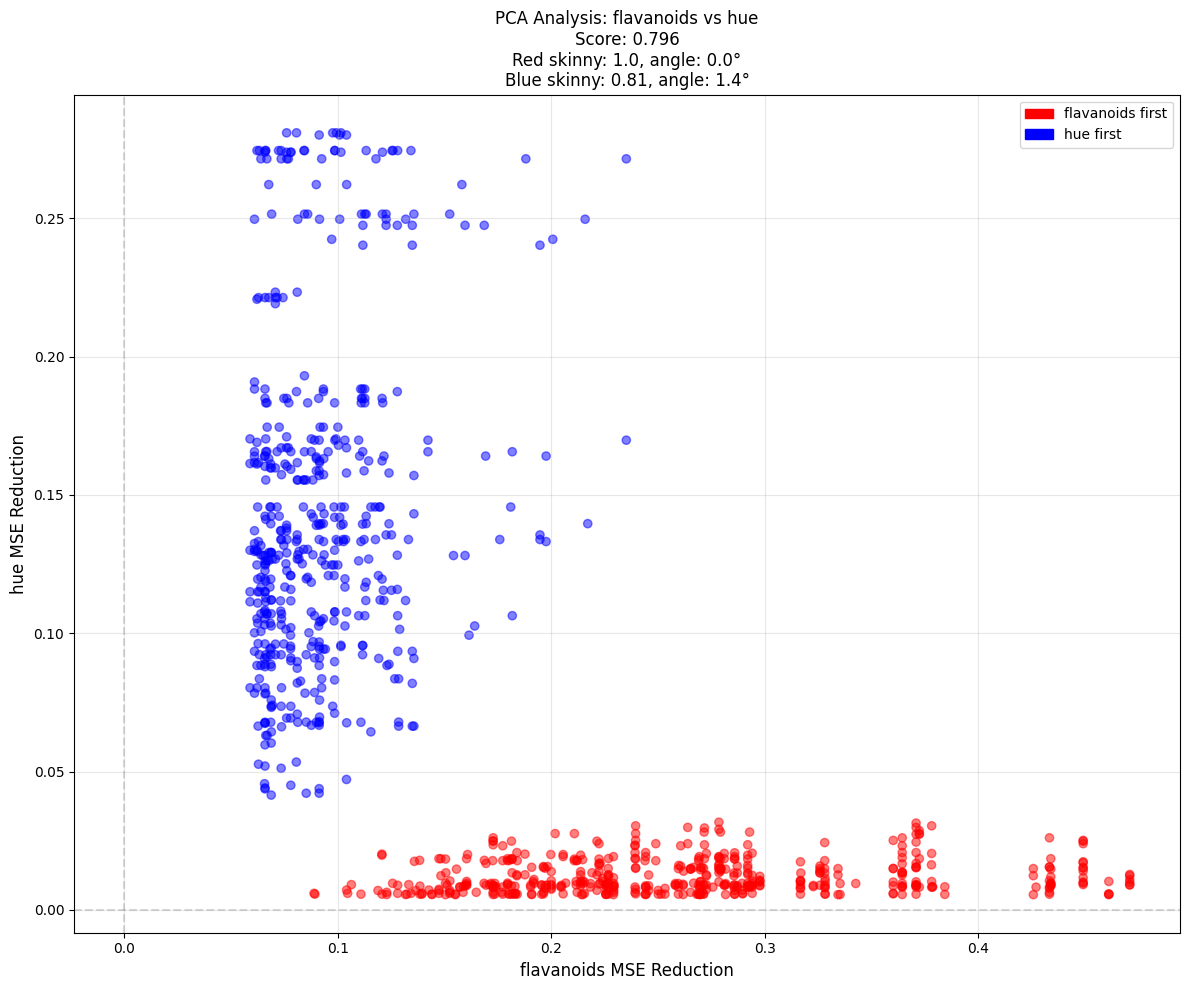

[0.98745128 0.01254872]
[0.72470451 0.27529549]


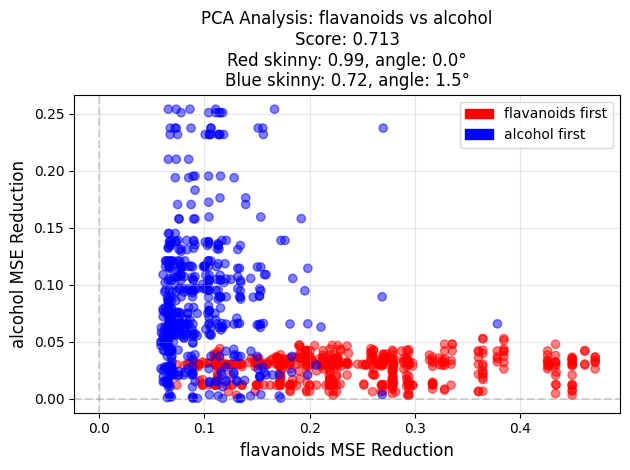

[0.99732309 0.00267691]
[0.71535882 0.28464118]


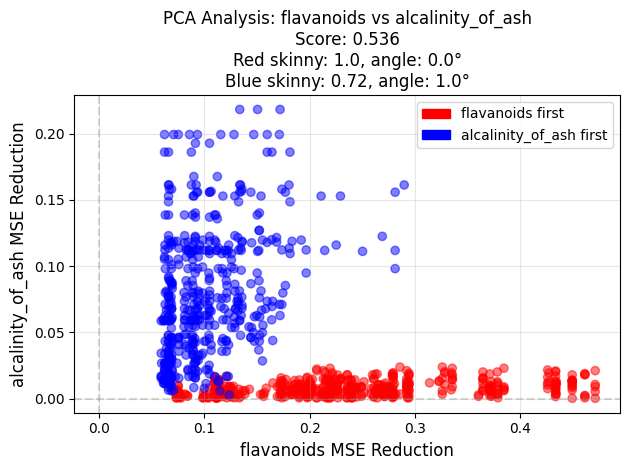

[9.99802089e-01 1.97911251e-04]
[0.70696729 0.29303271]


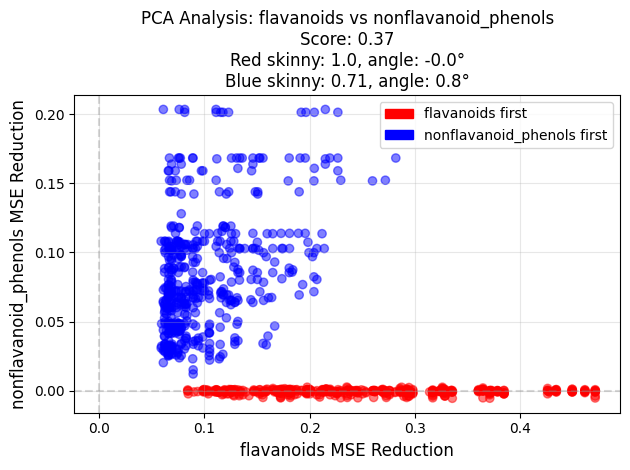

[9.99655387e-01 3.44613449e-04]
[0.70287096 0.29712904]


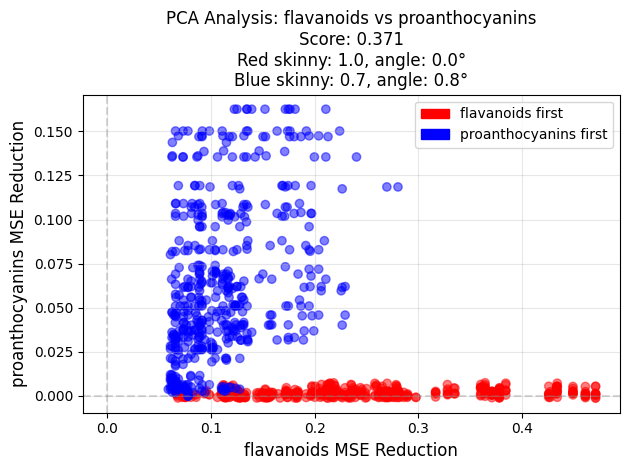

[0.98530164 0.01469836]
[0.572834 0.427166]


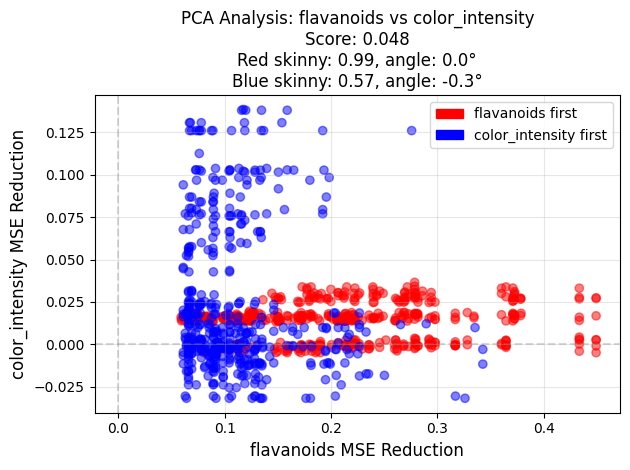

[9.99390081e-01 6.09918624e-04]
[0.60774185 0.39225815]


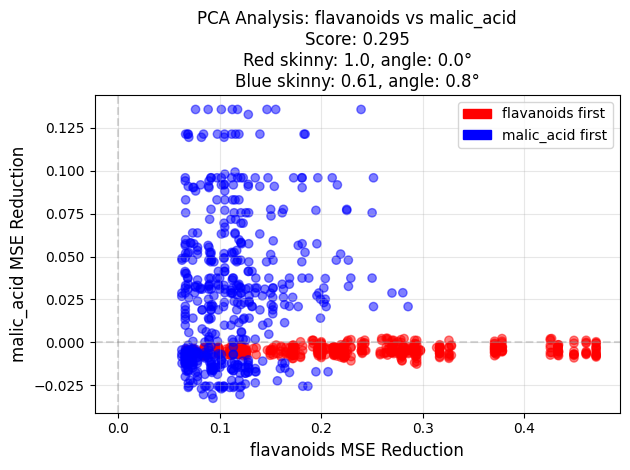

[0.99586649 0.00413351]
[0.58813784 0.41186216]


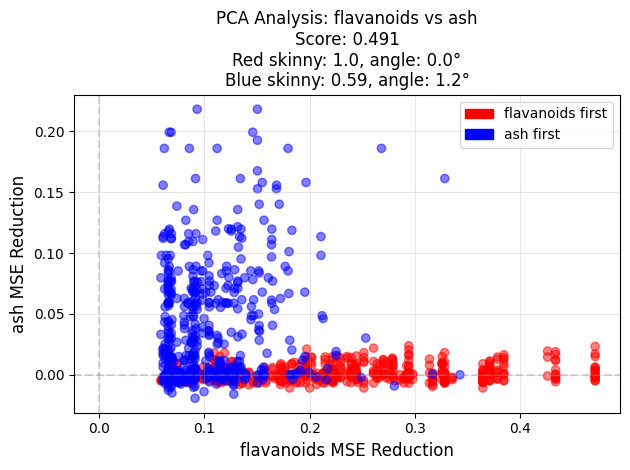

[9.99709446e-01 2.90553785e-04]
[0.93713518 0.06286482]


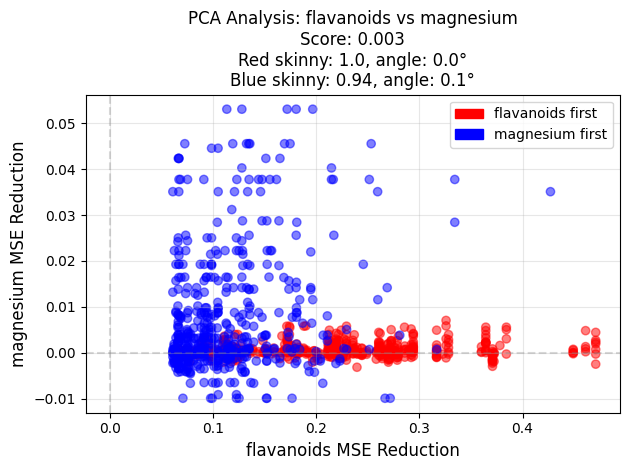

[0.92398646 0.07601354]
[0.70826494 0.29173506]


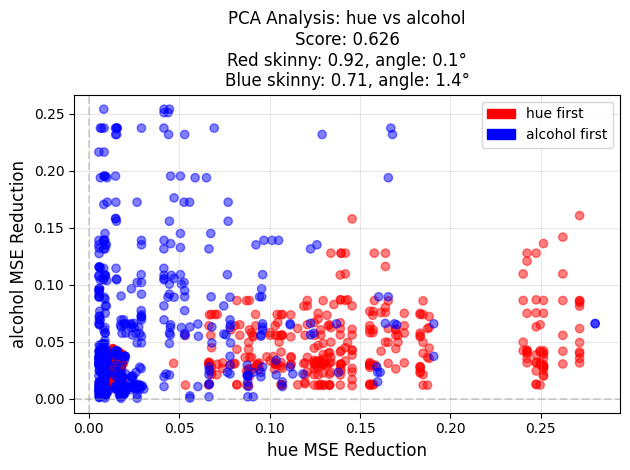

[0.97424778 0.02575222]
[0.81781438 0.18218562]


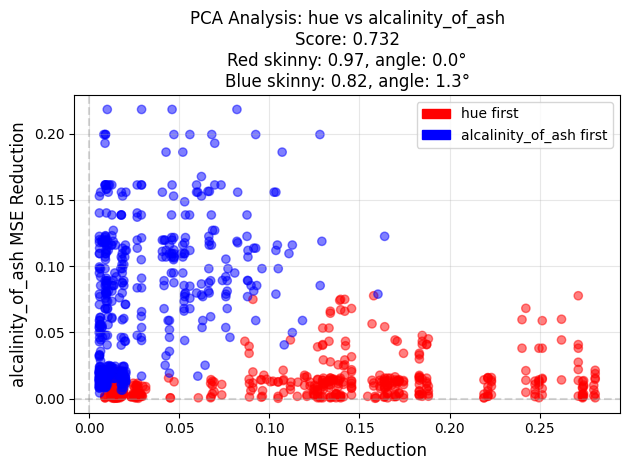

[0.9461278 0.0538722]
[0.79525315 0.20474685]


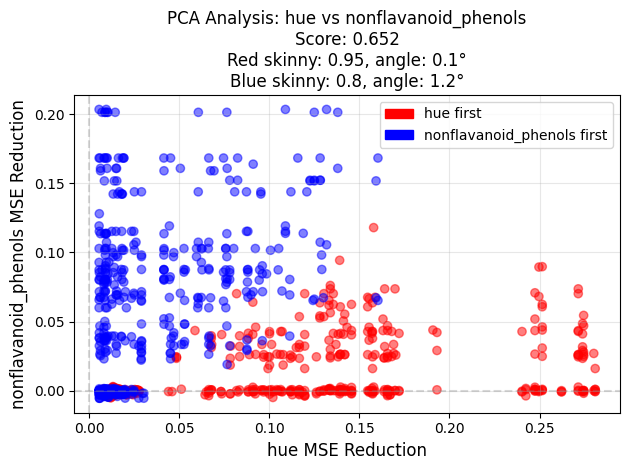

[0.99122335 0.00877665]
[0.78795046 0.21204954]


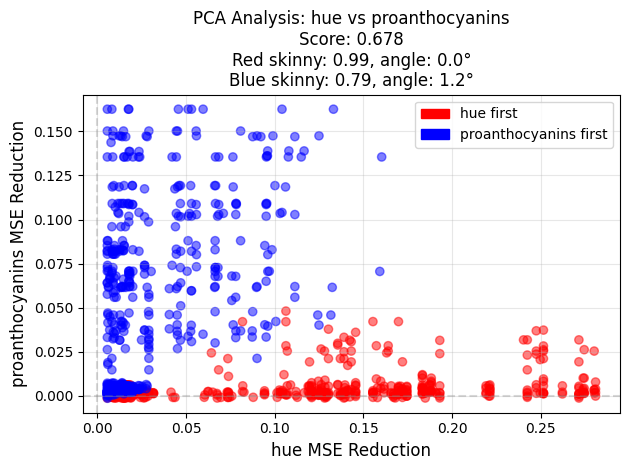

[0.98344073 0.01655927]
[0.59685313 0.40314687]


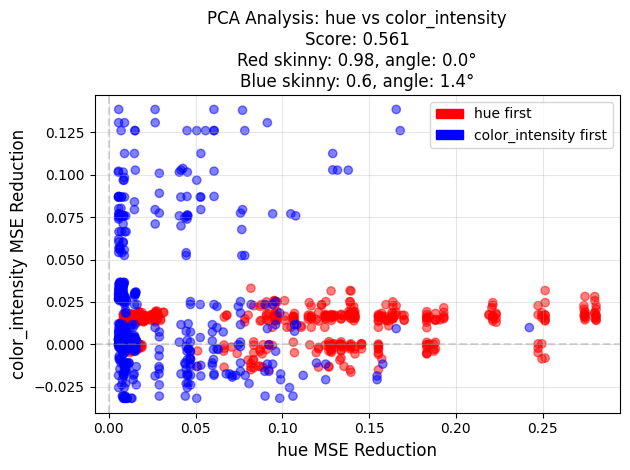

[0.99821543 0.00178457]
[0.72035248 0.27964752]


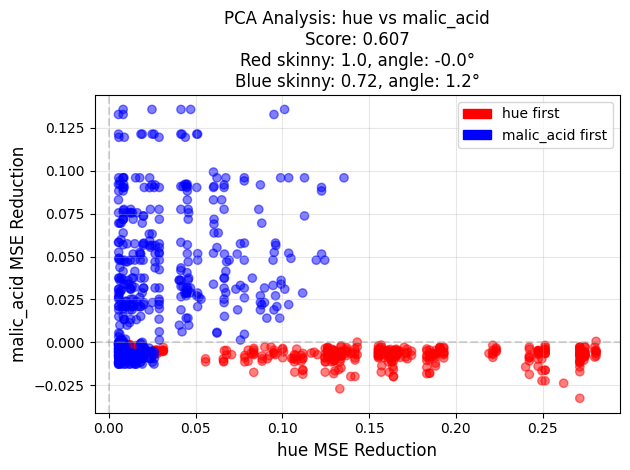

[0.97493433 0.02506567]
[0.70735108 0.29264892]


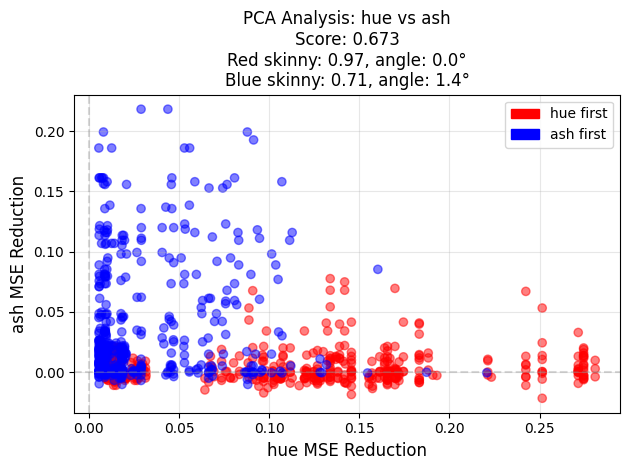

[9.99282366e-01 7.17634173e-04]
[0.88909732 0.11090268]


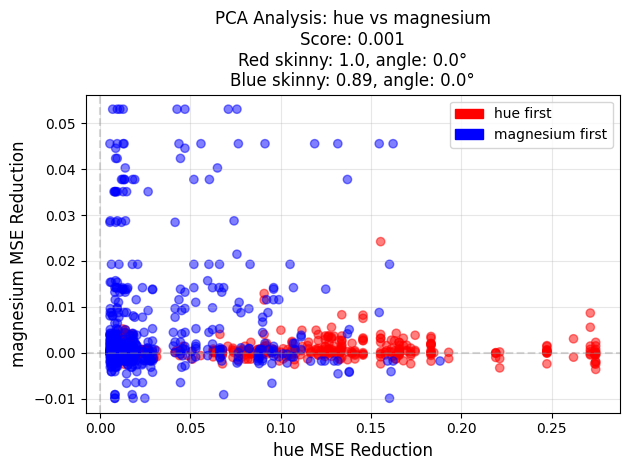

[0.94407476 0.05592524]
[0.86064595 0.13935405]


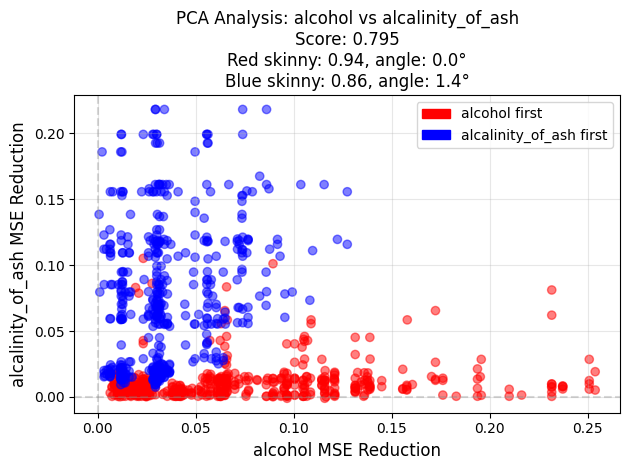

[0.92880272 0.07119728]
[0.87948054 0.12051946]


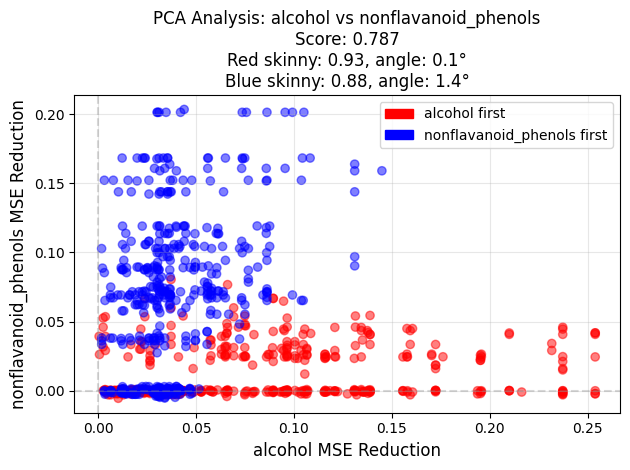

[0.96136066 0.03863934]
[0.78096592 0.21903408]


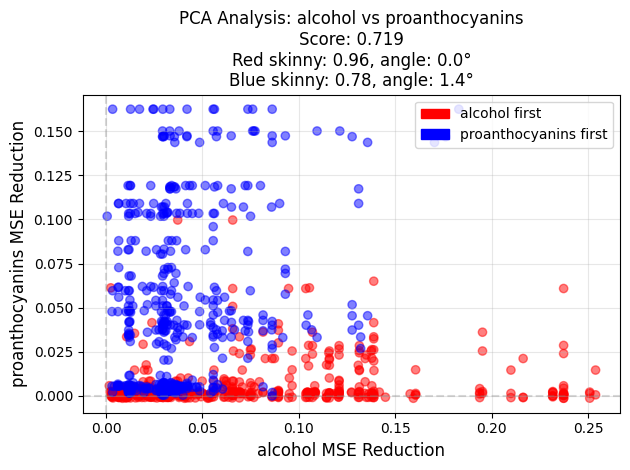

[0.82726271 0.17273729]
[0.88956482 0.11043518]


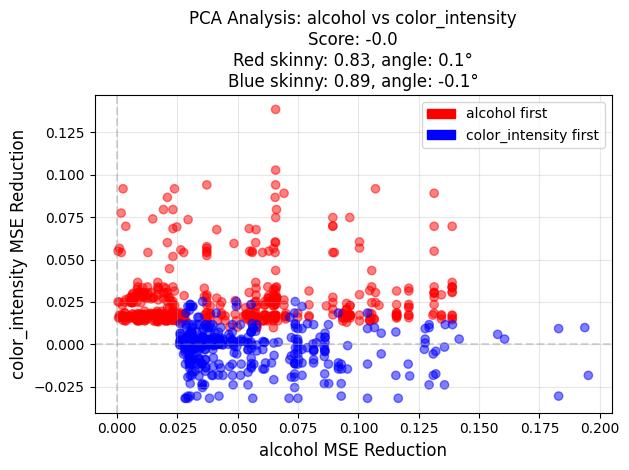

[0.93792178 0.06207822]
[0.61829851 0.38170149]


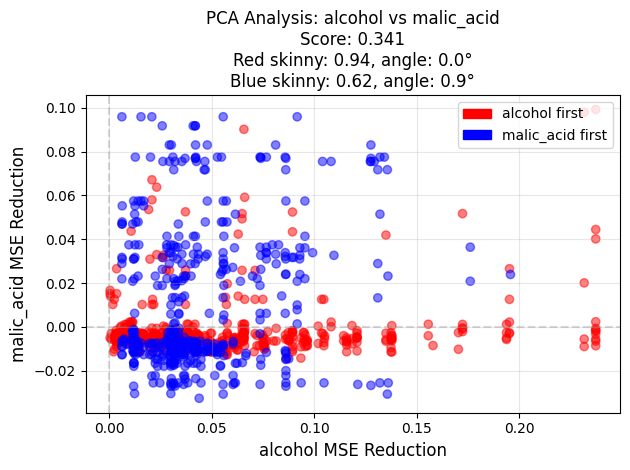

[0.96120135 0.03879865]
[0.79689714 0.20310286]


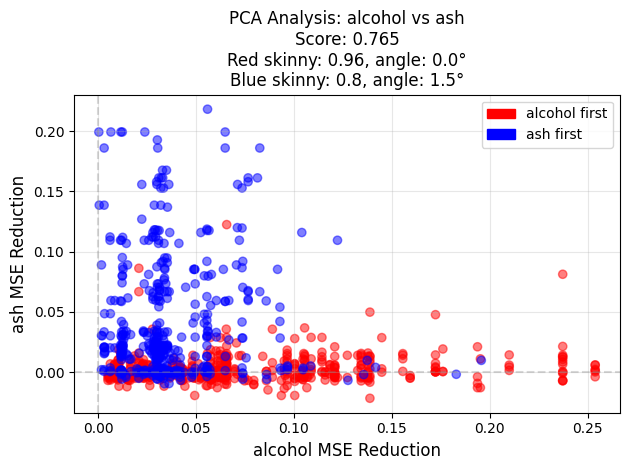

[9.99394939e-01 6.05060816e-04]
[0.87972322 0.12027678]


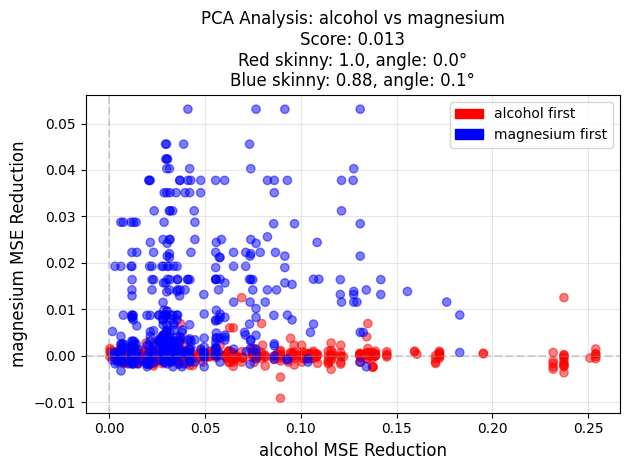

[0.91403069 0.08596931]
[0.90063083 0.09936917]


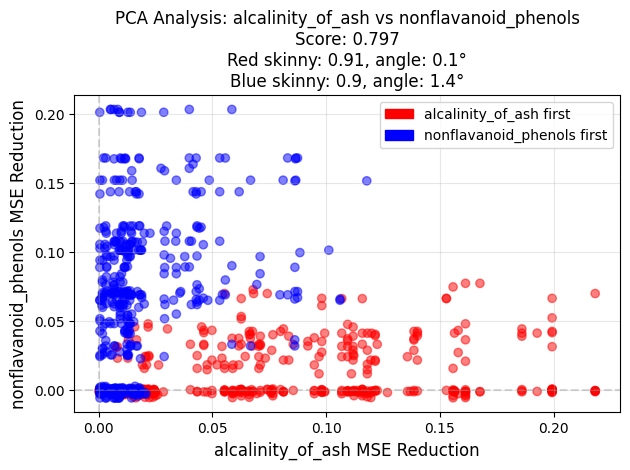

[0.95070179 0.04929821]
[0.82928584 0.17071416]


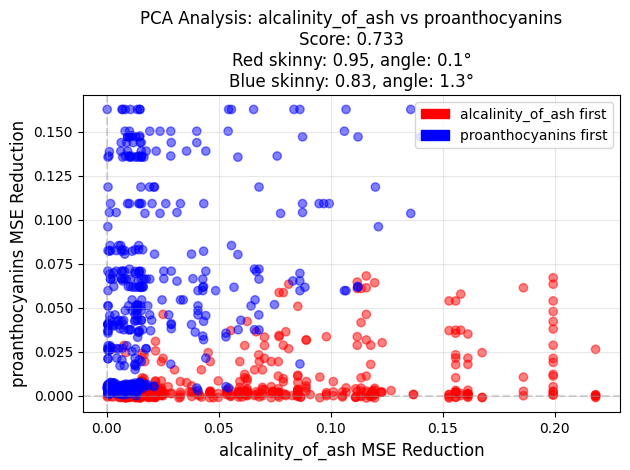

[0.89738542 0.10261458]
[0.77954346 0.22045654]


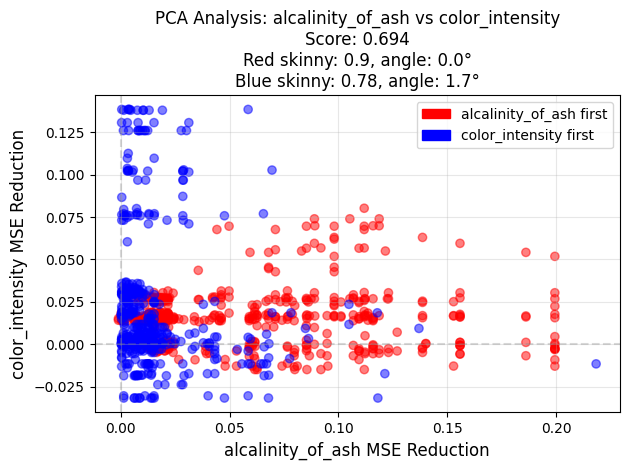

[0.96396322 0.03603678]
[0.81222839 0.18777161]


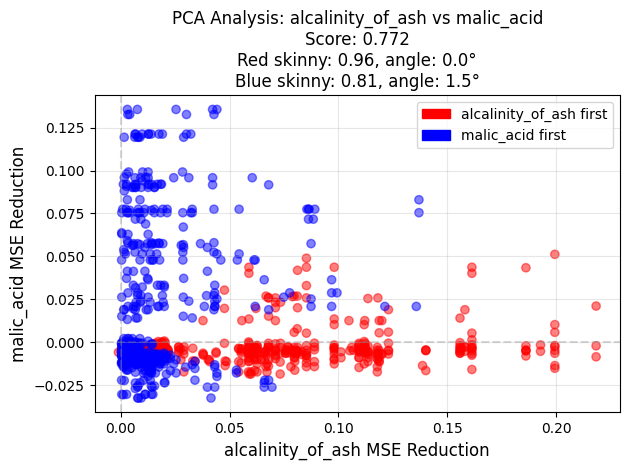

[0.95190367 0.04809633]
[0.9866506 0.0133494]


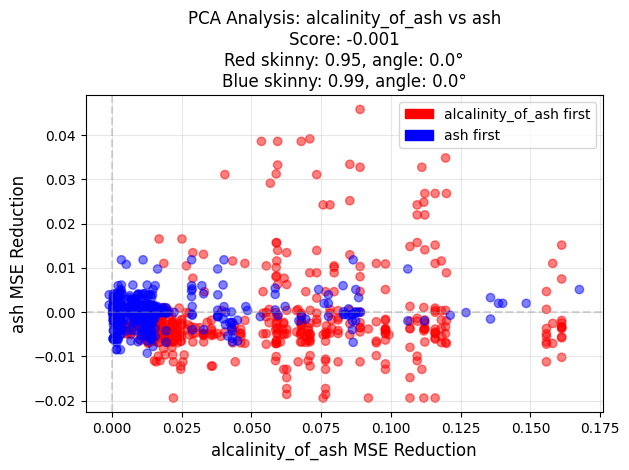

[0.99619717 0.00380283]
[0.86040557 0.13959443]


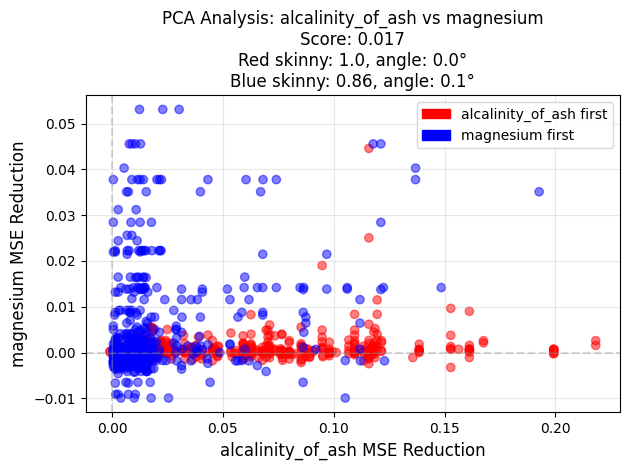

[0.9765717 0.0234283]
[0.91162178 0.08837822]


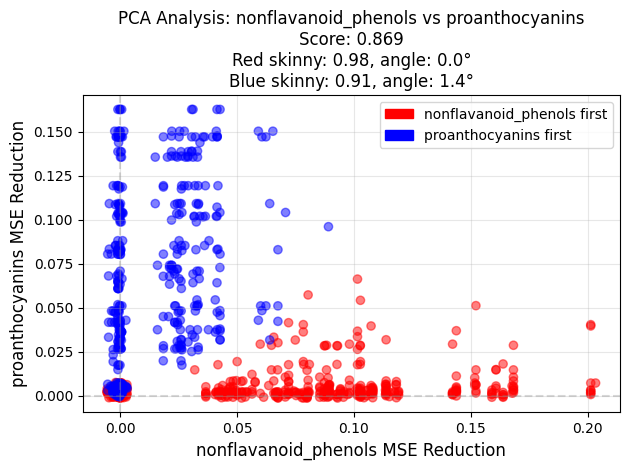

[0.89374164 0.10625836]
[0.73256715 0.26743285]


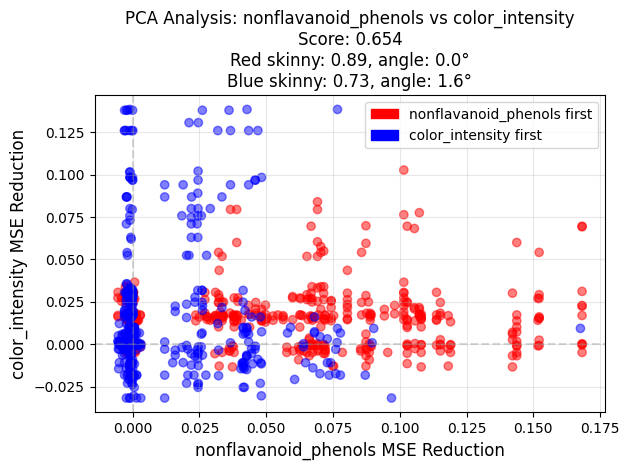

[0.95793285 0.04206715]
[0.81148591 0.18851409]


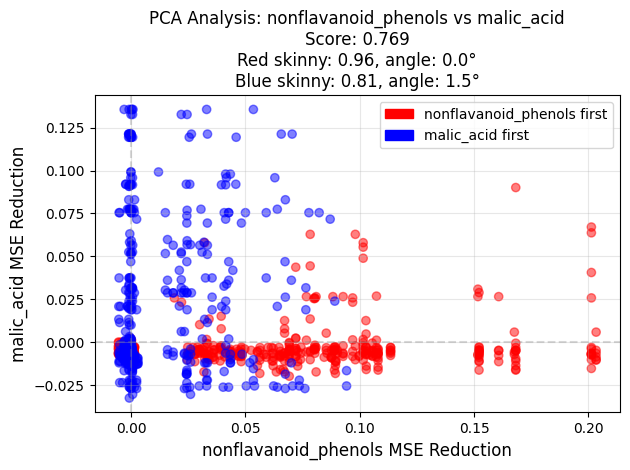

[0.94175661 0.05824339]
[0.83990642 0.16009358]


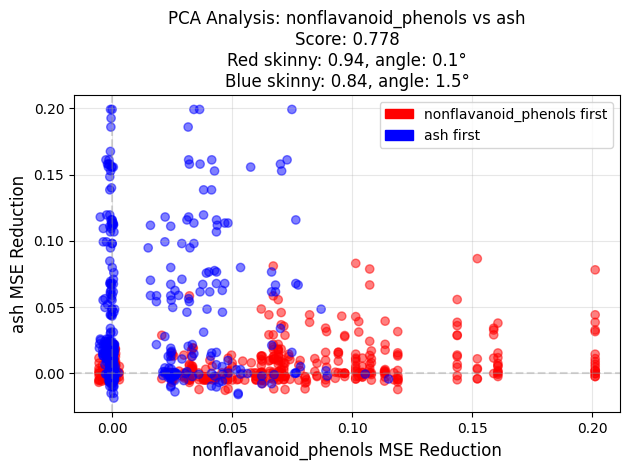

[9.99049362e-01 9.50637968e-04]
[0.75967585 0.24032415]


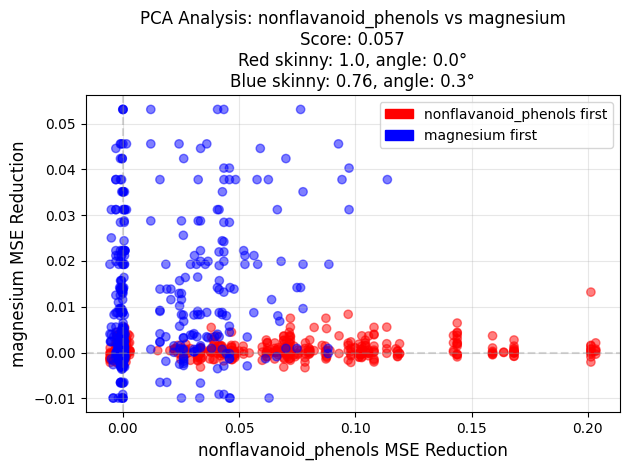

[0.89657476 0.10342524]
[0.89681808 0.10318192]


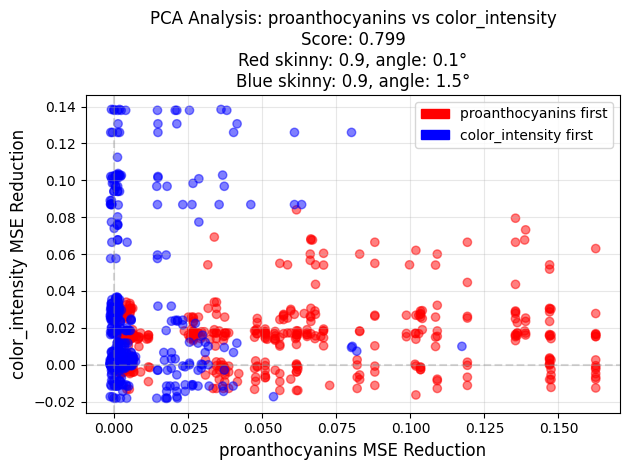

[0.95484944 0.04515056]
[0.93135198 0.06864802]


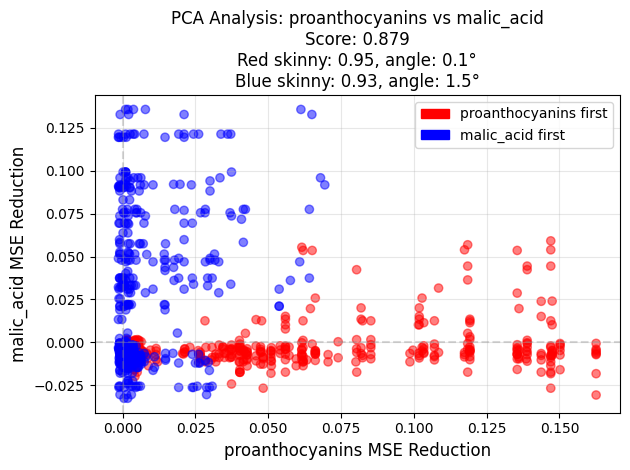

[0.87473799 0.12526201]
[0.91572055 0.08427945]


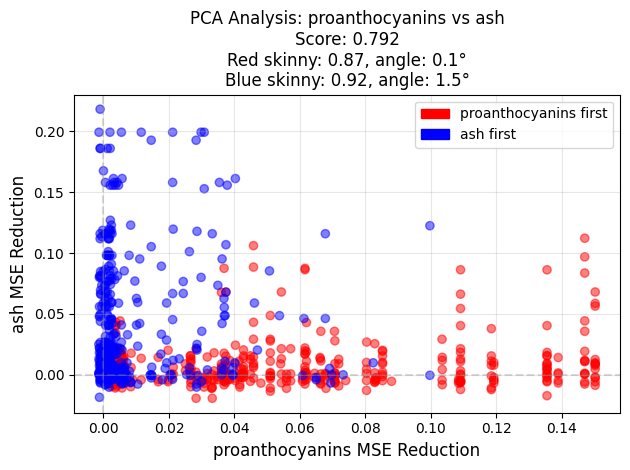

[0.99725287 0.00274713]
[0.68331862 0.31668138]


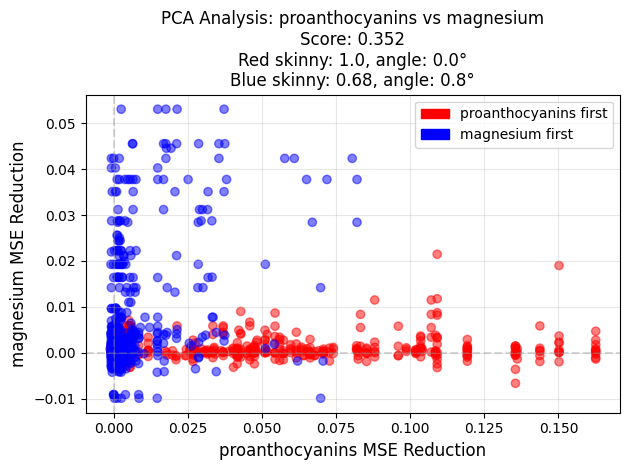

[0.88203181 0.11796819]
[0.85867963 0.14132037]


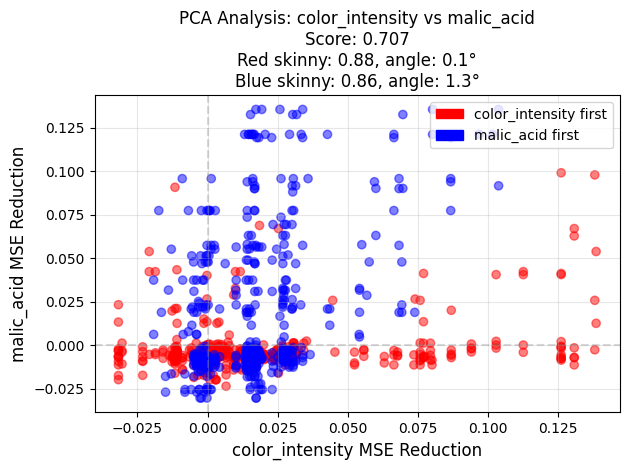

[0.83858418 0.16141582]
[0.81167923 0.18832077]


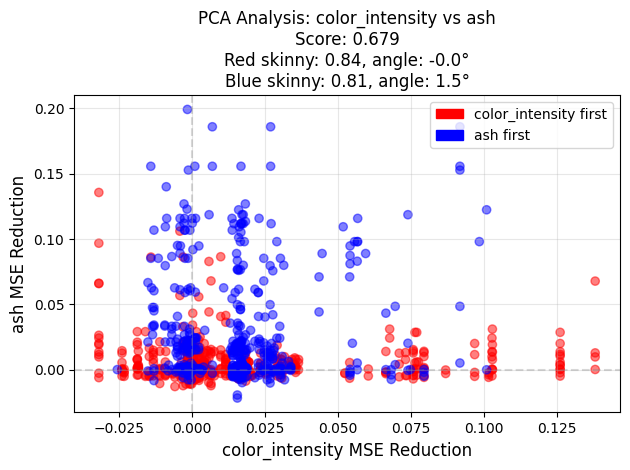

[0.99502232 0.00497768]
[0.77372306 0.22627694]


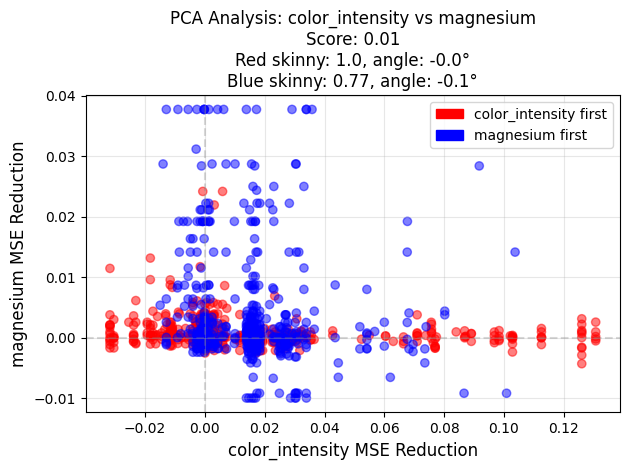

[0.88183727 0.11816273]
[0.92539528 0.07460472]


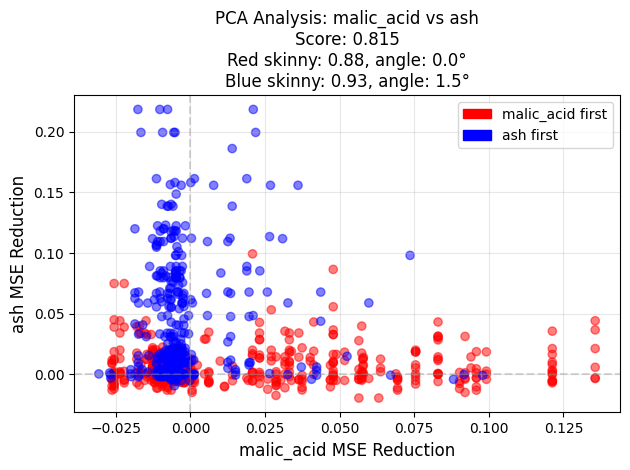

[0.99451221 0.00548779]
[0.67434467 0.32565533]


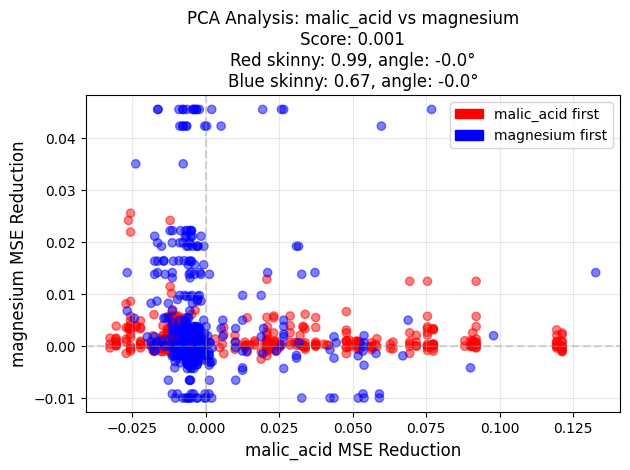

[0.99741399 0.00258601]
[0.62066408 0.37933592]


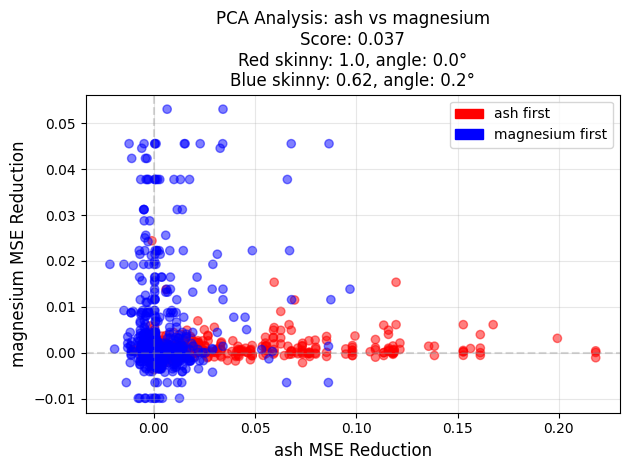

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
from sklearn.decomposition import PCA

# Function to compute PCA metrics safely
def compute_pca_metrics(data):
    """Computes skinniness and horizontalness from PCA with error handling"""
    if len(data) < 3:  # Too few points for PCA
        return 1, 0, 0  # Neutral values
    
    pca = PCA(n_components=2)
    pca.fit(data)
    
    # Compute skinniness (avoid division errors)
    explained_variance = pca.explained_variance_ratio_
    ## skinniness between 0 and 1
    print(explained_variance)
    skinniness = explained_variance[0] / explained_variance[1]
    skinniness = skinniness / (1 + skinniness)
    
    # Compute angle of first principal component
    first_component = pca.components_[0]
    angle = np.degrees(np.arctan2(first_component[1], first_component[0]))
    # angle = angle 
    # angle = np.clip(angle, -np.pi, np.pi)  # Ensure within expected range÷
    
    # Convert angle to horizontalness score
    horizontalness = np.cos(2 * np.radians(angle))
    # print(horizontalness)
    
    return skinniness, horizontalness, angle

# Get unique features from the dataframe
features = impact_df['added_feature'].unique()

# Create pairs of features
# feature_pairs = [('bmi', 'age')]
feature_pairs = combinations(features, 2)
print(feature_pairs)

# Create one large plot
plt.figure(figsize=(12, 10))

for feature_pair in feature_pairs:
    feature1, feature2 = feature_pair  # Get the single pair
    points = []  # Store (x, y, color)

    for row in impact_df.itertuples(index=False):
        if feature1 in row.added_feature and feature2 not in row.base_features:
            for row2 in impact_df.itertuples(index=False):
                if set(row.final_features) <= set(row2.base_features) and feature2 in row2.added_feature:
                    points.append((row.mse_reduction, row2.mse_reduction, 'red'))
        elif feature2 in row.added_feature and feature1 not in row.base_features:
            for row2 in impact_df.itertuples(index=False):
                if set(row.final_features) <= set(row2.base_features) and feature1 in row2.added_feature:
                    points.append((row2.mse_reduction, row.mse_reduction, 'blue'))

        # Handle feature1 or feature2 being the only feature present
        elif set([row.base_features]) == {feature1}:  # Only feature1 is added
            points.append((row.mse_reduction, 0, 'red'))
        elif set([row.base_features]) == {feature2}:  # Only feature2 is added
            points.append((0, row.mse_reduction, 'blue'))

    # Extract values for plotting
    if points:
        red_points = [p for p in points if p[2] == 'red']
        blue_points = [p for p in points if p[2] == 'blue']

        # Sample up to 800 points for efficiency
        red_points = random.sample(red_points, min(len(red_points), 500))
        blue_points = random.sample(blue_points, min(len(blue_points), 500))

        points = red_points + blue_points
        
        # Convert to numpy arrays for PCA
        x_vals, y_vals, colors = zip(*points)
        x_vals, y_vals = np.array(x_vals), np.array(y_vals)

        # Prepare data for PCA
        red_array = np.array([(x, y) for x, y, c in points if c == 'red'])
        blue_array = np.array([(x, y) for x, y, c in points if c == 'blue'])

        # Compute PCA metrics with fixes
        red_skinny, red_horiz, red_angle = compute_pca_metrics(red_array)
        blue_skinny, blue_horiz, blue_angle = compute_pca_metrics(blue_array)

        # Compute L-score safely
        L_score = (red_skinny * blue_skinny) * (red_horiz - blue_horiz) / 2
        # L_score = round(np.clip(L_score, -1, 1), 3)  # Clip to avoid extreme values
        L_score = round(L_score, 3)

    else:
        x_vals, y_vals, colors = [], [], []
        L_score = None  # No valid data for computation

    # Scatter plot
    plt.scatter(x_vals, y_vals, c=colors, alpha=0.5)

    # Add reference lines
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

    # plot the pca lines using the pca.components_

    # Set title with L-score and PCA details
    if L_score is not None:
        plt.title(
            f'PCA Analysis: {feature1} vs {feature2}\n'
            f'Score: {L_score}\n'
            # angle from pi to radians
            f'Red skinny: {round(red_skinny, 2)}, angle: {round((np.deg2rad(red_angle)), 1)}°\n'
            f'Blue skinny: {round(blue_skinny, 2)}, angle: {round((np.deg2rad(blue_angle)), 1)}°',
            fontsize=12
        )
    else:
        plt.title(f'{feature1} vs {feature2} | No Valid Data', fontsize=14)

    plt.xlabel(f'{feature1} MSE Reduction', fontsize=12)
    plt.ylabel(f'{feature2} MSE Reduction', fontsize=12)

    # Add custom legend
    red_patch = mpatches.Patch(color='red', label=f'{feature1} first')
    blue_patch = mpatches.Patch(color='blue', label=f'{feature2} first')
    plt.legend(handles=[red_patch, blue_patch], loc='upper right')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
